<a href="https://colab.research.google.com/github/flyingbobs/dacon/blob/main/catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# * Import

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# visualize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# preprocess
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# ML learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import log_loss # multi-class classification

# ML model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = "drive/MyDrive/colab/Dacon/FSI_FRAUD/data/"
train = pd.read_csv(root_path+'train.csv')
test  = pd.read_csv(root_path+'test.csv')
submission = pd.read_csv(root_path+'sample_submission.csv')

# 1. Basic EDA

### 1-1. Schema

In [ ]:
train.shape

(120000, 64)

In [ ]:
train.head()

,ID,Customer_Birthyear,Customer_Gender,Customer_personal_identifier,Customer_identification_number,Customer_registration_datetime,Customer_credit_rating,Customer_flag_change_of_authentication_1,Customer_flag_change_of_authentication_2,Customer_flag_change_of_authentication_3,...,Last_atm_transaction_datetime,Last_bank_branch_transaction_datetime,Flag_deposit_more_than_tenMillion,Unused_account_status,Recipient_account_suspend_status,Number_of_transaction_with_the_account,Transaction_history_with_the_account,First_time_iOS_by_vulnerable_user,Fraud_Type,Transaction_resumed_date
0,TRAIN_000000,1980,male,이상호,BJWQxd-WBASPLJ,2003-01-06 18:38:01,B,0,1,0,...,2003-01-22 23:38:48,2003-01-22 23:38:48,1,1,1,0,0,0,m,2003-01-22 23:38:48
1,TRAIN_000001,1964,male,박상철,kurCwX-odPUXEt,2003-01-07 16:40:44,C,0,1,0,...,2003-01-21 21:29:08,2003-01-31 00:19:46,0,1,0,0,0,0,m,2003-01-19 21:29:08
2,TRAIN_000002,1982,female,조옥자,OiERQa-CTXBoaX,2003-01-11 14:08:36,B,1,1,0,...,2003-01-31 07:13:28,2003-01-31 07:13:28,0,0,1,1,1,0,m,2003-01-31 07:13:28
3,TRAIN_000003,1982,female,조옥자,OiERQa-CTXBoaX,2003-01-11 14:08:36,B,1,1,1,...,2003-01-31 11:49:56,2003-01-31 07:13:28,1,1,0,0,0,0,m,2003-01-31 07:13:28
4,TRAIN_000004,1982,female,조옥자,OiERQa-CTXBoaX,2003-01-11 14:08:36,B,1,1,1,...,2003-01-31 11:49:56,2003-01-31 07:13:28,1,0,0,1,1,0,m,2003-01-31 07:13:28


In [ ]:
train.info()

### 1-2. Missing Value

In [ ]:
# check null value
train.isnull().sum().loc[lambda x:x>0]

,0


### 1-3. Plot Histogram

In [ ]:
sample_df = train.sample(frac=0.1)

In [ ]:
hist_vars = list(train.columns)

# remove inappropriate columns to plot distribution (ex. timestamp, idetifier)
pass_vars = ([
    ## identifier
    'ID', 'Customer_personal_identifier', 'Customer_identification_number','Account_account_number',  'Recipient_Account_Number',
    ## timestamp
    'Customer_registration_datetime', 'Account_creation_datetime', 'Last_atm_transaction_datetime', 'Last_bank_branch_transaction_datetime', 'Transaction_resumed_date', 'Transaction_Datetime', 'Time_difference',
    ## access env
    'IP_Address', 'MAC_Address',  'Location',
])

hist_vars = sorted([x for x in hist_vars if x not in pass_vars])
print(len(hist_vars))
print(hist_vars) # 52

49
['Access_Medium', 'Account_account_type', 'Account_amount_daily_limit', 'Account_balance', 'Account_dawn_one_month_max_amount', 'Account_dawn_one_month_std_dev', 'Account_indicator_Openbanking', 'Account_indicator_release_limit_excess', 'Account_initial_balance', 'Account_one_month_max_amount', 'Account_one_month_std_dev', 'Account_release_suspention', 'Account_remaining_amount_daily_limit_exceeded', 'Another_Person_Account', 'Channel', 'Customer_Birthyear', 'Customer_Gender', 'Customer_VPN_Indicator', 'Customer_credit_rating', 'Customer_flag_change_of_authentication_1', 'Customer_flag_change_of_authentication_2', 'Customer_flag_change_of_authentication_3', 'Customer_flag_change_of_authentication_4', 'Customer_flag_terminal_malicious_behavior_1', 'Customer_flag_terminal_malicious_behavior_2', 'Customer_flag_terminal_malicious_behavior_3', 'Customer_flag_terminal_malicious_behavior_4', 'Customer_flag_terminal_malicious_behavior_5', 'Customer_flag_terminal_malicious_behavior_6', 'Cust

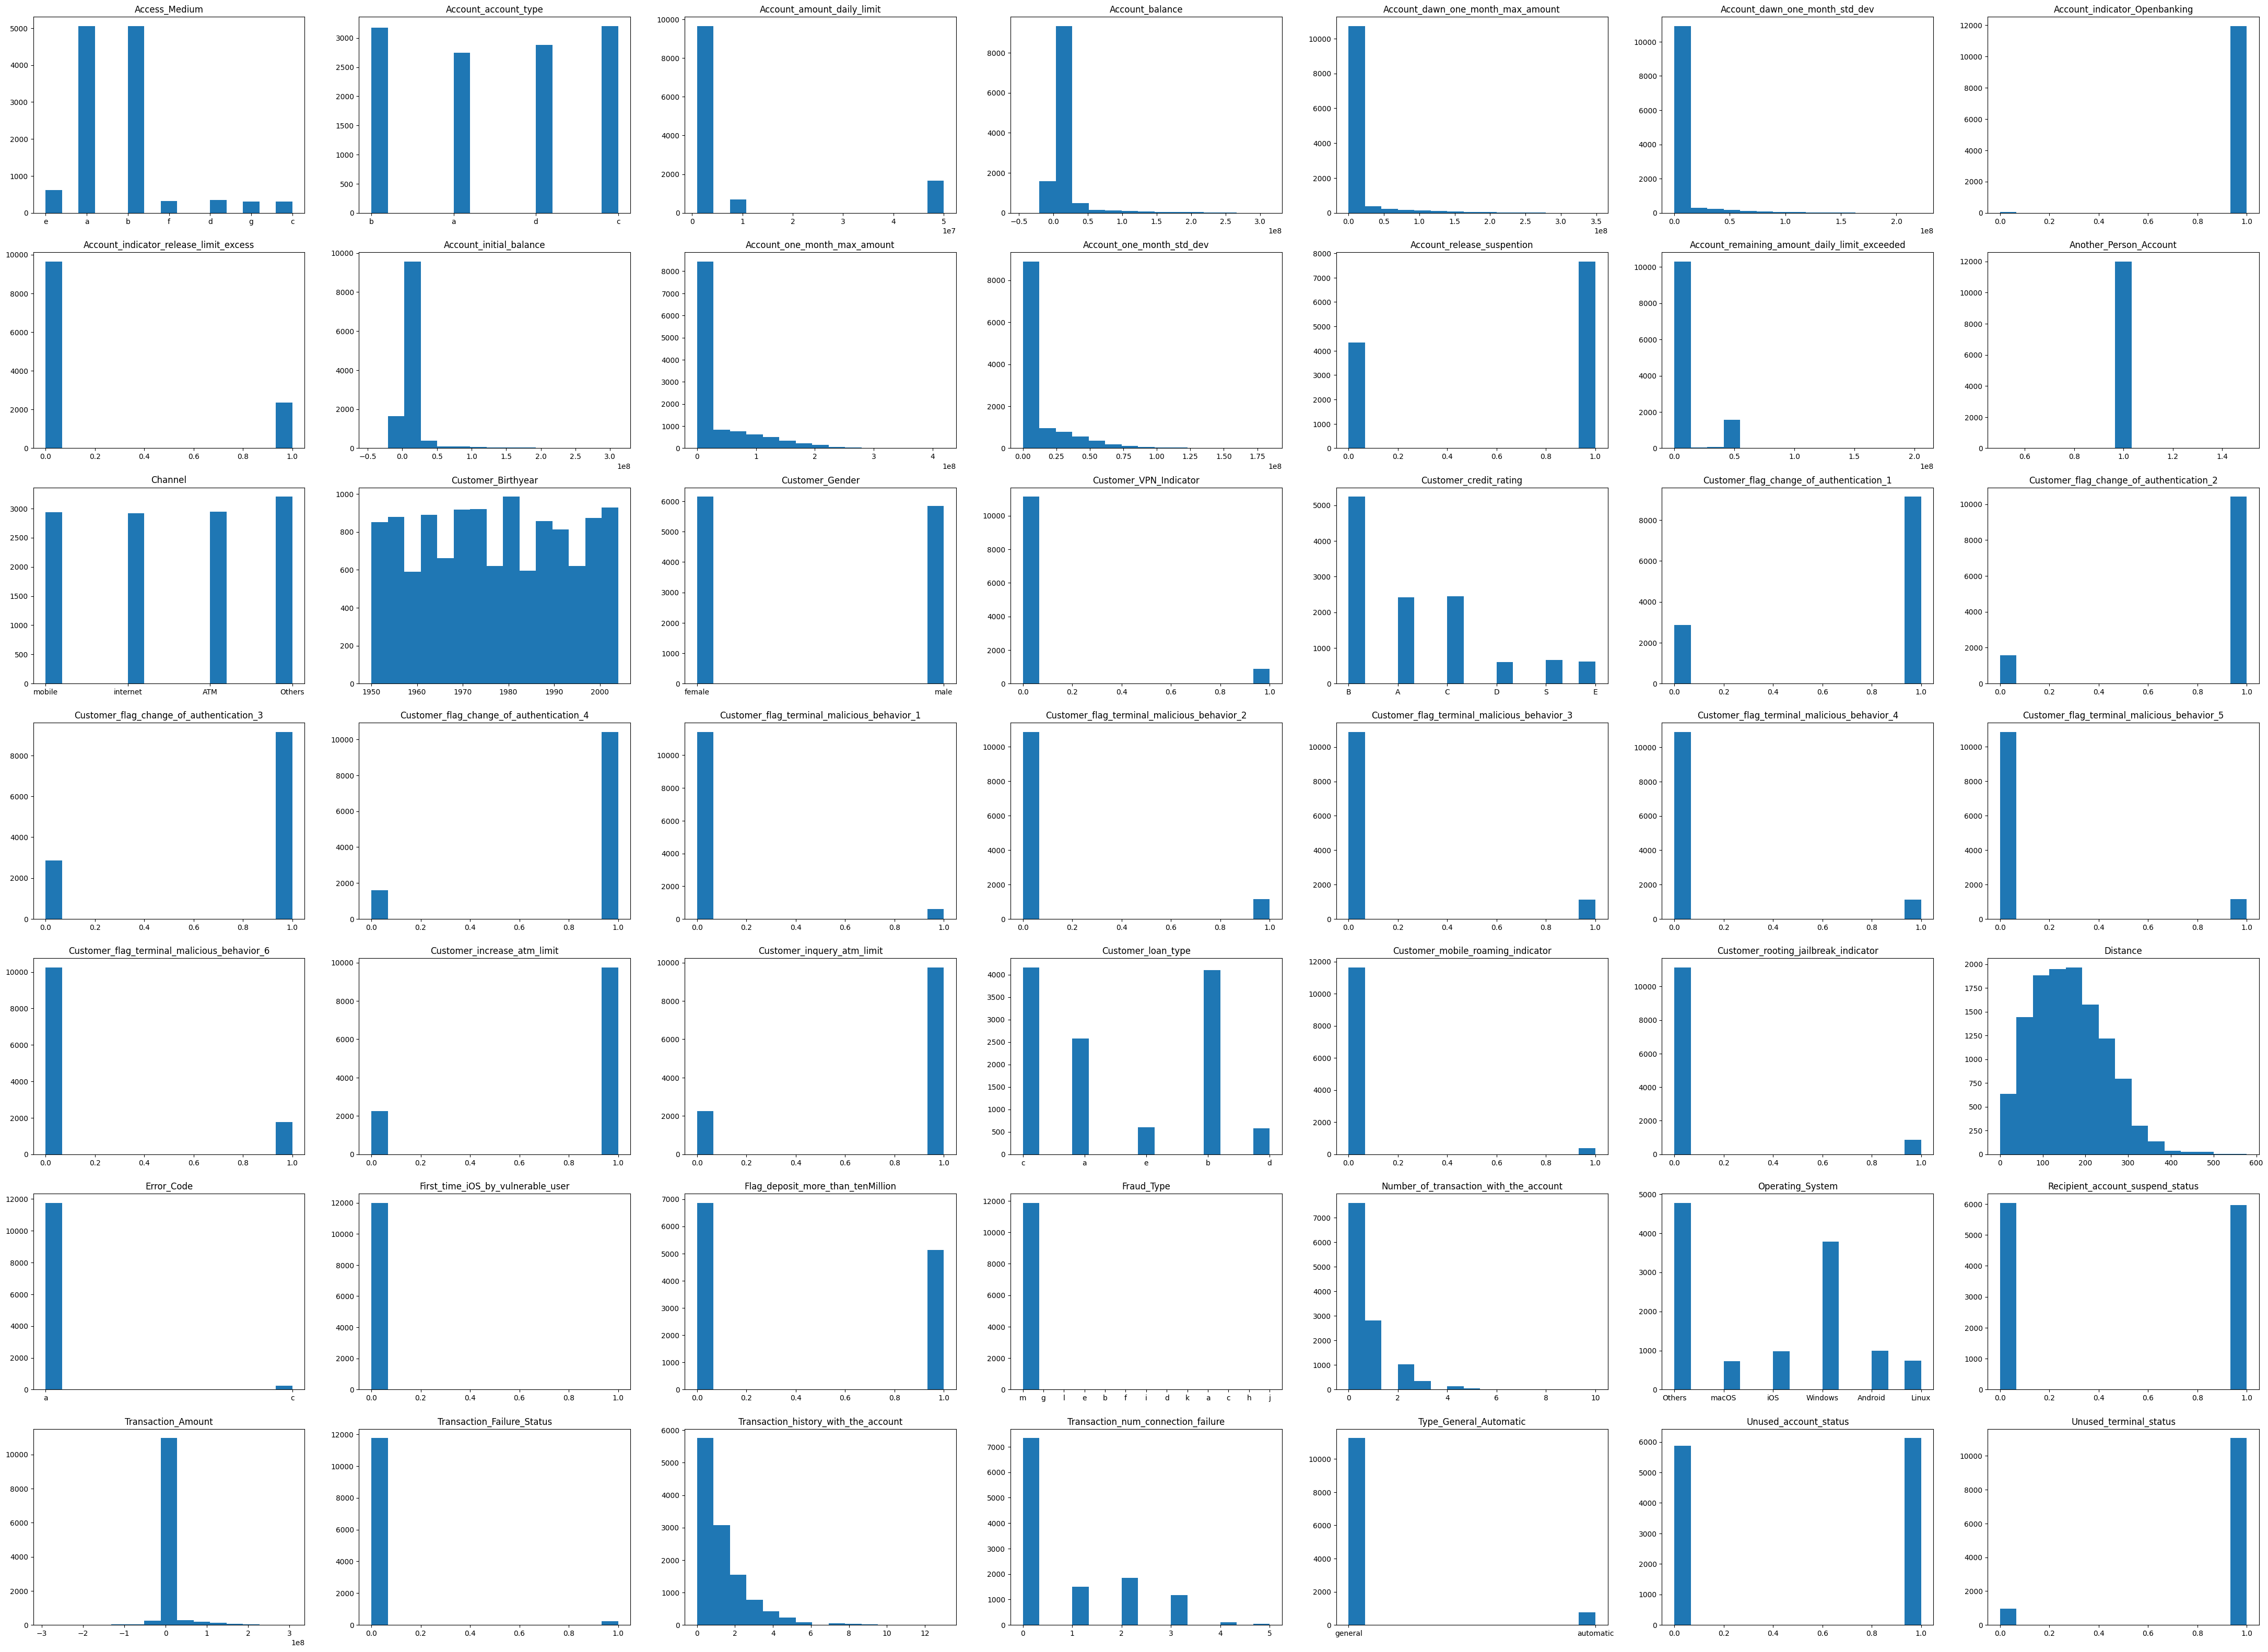

In [ ]:
n_row, n_col = 7, 7
fig, axs = plt.subplots(n_row, n_col, figsize=(55, 40)) # 50, 40

for r in range(n_row):
  for c in range(n_col):
    idx = n_col*r+c
    if idx >= len(target_vars): continue
    var = target_vars[idx]

    try:
      axs[r, c].hist(sample_df[var], 15)
      axs[r, c].set_title(var)
    except Exception as e:
      print("column = ", var, " / error_message = ", e)

# 2. Feature Engineering

### 2-1. modify / create new variables

In [ ]:
new_vars      = []

In [ ]:
datetime_vars = ['Customer_registration_datetime', 'Account_creation_datetime', 'Last_atm_transaction_datetime','Last_bank_branch_transaction_datetime', 'Transaction_resumed_date']

for var in datetime_vars:
  new_var = '_'.join(var.split("_")[:-1]) + "_daydiff"
  new_vars.append(new_var)

  train[new_var] = pd.to_datetime(train['Transaction_Datetime']) -  pd.to_datetime(train[var])
  train[new_var] = train[new_var].map(lambda x:x.days)

  test[new_var] = pd.to_datetime(test['Transaction_Datetime']) -  pd.to_datetime(test[var])
  test[new_var] = test[new_var].map(lambda x:x.days)

In [ ]:
new_vars.append('Last_transaction_daydiff')
train['Last_transaction_daydiff'] = train['Time_difference'].map(lambda x:pd.to_timedelta(x).days)
test['Last_transaction_daydiff']  = test['Time_difference'].map(lambda x:pd.to_timedelta(x).days)

In [ ]:
new_vars.append('Customer_age')
def get_age(curtime, birthyear): return pd.to_datetime(curtime).year - int(birthyear)
train['Customer_age'] = train[['Transaction_Datetime', 'Customer_Birthyear']].apply(lambda x:get_age(*x), axis=1)
test['Customer_age']  = test[['Transaction_Datetime',  'Customer_Birthyear']].apply(lambda x:get_age(*x), axis=1)

### 2-2. remove variables

In [ ]:
identifier_vars = [
    ## identifier
    'ID', 'Customer_personal_identifier', 'Customer_identification_number', 'Account_account_number','Recipient_Account_Number',
    ## access env
    'IP_Address', 'MAC_Address',  'Location',

]
delete_vars = identifier_vars + datetime_vars +  ['Transaction_Datetime', 'Time_difference', 'Customer_Birthyear']
train.drop(delete_vars, axis=1, inplace=True)
test.drop(delete_vars,  axis=1, inplace=True)

# 3. Preprocessing

##### * 변수 분류 (범주형 / 수치형)

In [ ]:
num_to_cat_vars = [
  'Customer_flag_change_of_authentication_1', 'Customer_flag_change_of_authentication_2', 'Customer_flag_change_of_authentication_3', 'Customer_flag_change_of_authentication_4',
  'Customer_rooting_jailbreak_indicator', 'Customer_mobile_roaming_indicator', 'Customer_VPN_Indicator',
  'Customer_flag_terminal_malicious_behavior_1', 'Customer_flag_terminal_malicious_behavior_2', 'Customer_flag_terminal_malicious_behavior_3',
  'Customer_flag_terminal_malicious_behavior_4','Customer_flag_terminal_malicious_behavior_5', 'Customer_flag_terminal_malicious_behavior_6',
  'Customer_flag_change_of_authentication_1', 'Customer_flag_change_of_authentication_2', 'Customer_flag_change_of_authentication_3', 'Customer_flag_change_of_authentication_4',
  'Customer_rooting_jailbreak_indicator', 'Customer_mobile_roaming_indicator', 'Customer_VPN_Indicator',
  'Customer_flag_terminal_malicious_behavior_1', 'Customer_flag_terminal_malicious_behavior_2', 'Customer_flag_terminal_malicious_behavior_3',
  'Customer_flag_terminal_malicious_behavior_4', 'Customer_flag_terminal_malicious_behavior_5', 'Customer_flag_terminal_malicious_behavior_6',
  'Customer_inquery_atm_limit', 'Customer_increase_atm_limit',
  'Account_indicator_release_limit_excess', 'Account_indicator_Openbanking', 'Account_release_suspention',
  'Transaction_Failure_Status','Unused_terminal_status', 'Unused_account_status',
  'Another_Person_Account','Flag_deposit_more_than_tenMillion', 'Recipient_account_suspend_status','First_time_iOS_by_vulnerable_user'
]

train = train.astype({v:'object' for v in num_to_cat_vars} )
test  = test.astype( {v:'object' for v in num_to_cat_vars} )

# independent variables
num_vars = train.dtypes[train.dtypes != "object"].index.tolist()
cat_vars = train.dtypes[train.dtypes == "object"].index.tolist()

# dependent variable
dep_var = 'Fraud_Type'
if dep_var in num_vars: num_vars.remove(dep_var)
if dep_var in cat_vars: cat_vars.remove(dep_var)

print("numerical_variables = ", num_vars)
print('categorical variables = ', cat_vars)
print('dependent variable = ', dep_var)

numerical_variables =  ['Account_initial_balance', 'Account_balance', 'Account_amount_daily_limit', 'Account_remaining_amount_daily_limit_exceeded', 'Account_one_month_max_amount', 'Account_one_month_std_dev', 'Account_dawn_one_month_max_amount', 'Account_dawn_one_month_std_dev', 'Transaction_Amount', 'Transaction_num_connection_failure', 'Distance', 'Number_of_transaction_with_the_account', 'Transaction_history_with_the_account', 'Customer_registration_daydiff', 'Account_creation_daydiff', 'Last_atm_transaction_daydiff', 'Last_bank_branch_transaction_daydiff', 'Transaction_resumed_daydiff', 'Last_transaction_daydiff', 'Customer_age']
categorical variables =  ['Customer_Gender', 'Customer_credit_rating', 'Customer_flag_change_of_authentication_1', 'Customer_flag_change_of_authentication_2', 'Customer_flag_change_of_authentication_3', 'Customer_flag_change_of_authentication_4', 'Customer_rooting_jailbreak_indicator', 'Customer_mobile_roaming_indicator', 'Customer_VPN_Indicator', 'Custom

##### * 수치형 변수 scaling

In [ ]:
# 1. Log Scale  * monetary variable
monetary_vars = []
for var in monetary_vars:
  train[var] = np.log1p(1 + train[var])
  test[var]  = np.log1p(1 + test[var])

# 2. Standard Scale
# num_vars.remove(*monetary_vars)
scaler = StandardScaler()
train[num_vars] = scaler.fit_transform(train[num_vars])
test[num_vars]  = scaler.transform(test[num_vars])

##### * 범주형 변수 encoding
* (skippable when using Tree-based model)

In [ ]:
# 3. Ordinal Encoding
encoder = OrdinalEncoder(cat_vars)
encoder.fit(train[cat_vars])

train[cat_vars] = encoder.transform(train[cat_vars])
test[cat_vars]  = encoder.transform(test[cat_vars])

# 4. Modeling

In [ ]:
seed = 42   # 고정
n_fold = 10 # 15
n_class = len(train[dep_var].unique())


In [ ]:
train_x, train_y = train.drop(dep_var, axis=1), train[dep_var]
train_y = LabelEncoder().fit_transform(train_y) # kfold.split() 에서 지원하는 target type 은 'binary' 혹은 'multiclass'

In [51]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds = []
for train_idx, valid_idx in skfold.split(train_x, train_y):
  folds.append((train_idx, valid_idx))

In [42]:
train_pred = np.zeros((train_x.shape[0],n_class))
test_pred  = np.zeros((test.shape[0],   n_class))

for fold_idx in range(n_fold):
  print(f'\n----------------- Fold {fold_idx} -----------------\n')

  fold_train_idx, fold_test_idx = folds[fold_idx]

  fold_train_x, fold_train_y = train_x.iloc[fold_train_idx], train_y[fold_train_idx],
  fold_test_x,  fold_test_y  = train_x.iloc[fold_test_idx],  train_y[fold_test_idx]

  # Pool : convenient data structure for CatBoost (instead of ndarray)
  # cat_features : need to pass cat feature names. Otherwise, it assumes all variables are numeric)
  fold_train_data = Pool(data=fold_train_x, label=fold_train_y, cat_features=cat_vars)
  fold_test_data  = Pool(data=fold_test_x,  label=fold_test_y,  cat_features=cat_vars)

  # model_cat = CatBoostClassifier()                           # remaining: 3h 52m 11s
  model_cat = CatBoostClassifier(task_type="GPU", devices='0') # remaining: 47.2s
  model_cat.fit(fold_train_data, eval_set=fold_test_data, use_best_model=True, early_stopping_rounds=100, verbose=100)

  fold_test_pred = model_cat.predict_proba(fold_test_x)
  train_pred[fold_test_idx] = fold_test_pred

  # accuracy
  acc = sum(fold_test_y == fold_test_pred.argmax(axis=1)) / len(fold_test_y)

  test_pred += model_cat.predict_proba(test) / n_fold
  fold_log_loss = log_loss(fold_test_y, fold_test_pred)
  print(f'Log Loss Score: {fold_log_loss:.6f}')
  print(f'Accuracy : {acc:.2f}')


----------------- Fold 0 -----------------

Learning rate set to 0.168736
0:	learn: 0.8992384	test: 0.8994751	best: 0.8994751 (0)	total: 38ms	remaining: 38s
100:	learn: 0.0221099	test: 0.0284837	best: 0.0284837 (100)	total: 2.12s	remaining: 18.9s
200:	learn: 0.0145725	test: 0.0251983	best: 0.0251983 (200)	total: 4.01s	remaining: 15.9s
300:	learn: 0.0106233	test: 0.0240460	best: 0.0240234 (298)	total: 5.98s	remaining: 13.9s
400:	learn: 0.0077440	test: 0.0228645	best: 0.0228645 (400)	total: 11.4s	remaining: 17s
500:	learn: 0.0057167	test: 0.0225828	best: 0.0225828 (500)	total: 13.3s	remaining: 13.2s
600:	learn: 0.0044080	test: 0.0227709	best: 0.0225389 (553)	total: 15.2s	remaining: 10.1s
bestTest = 0.02253888448
bestIteration = 553
Shrink model to first 554 iterations.
Log Loss Score: 0.022539
Accuracy : 0.99

----------------- Fold 1 -----------------

Learning rate set to 0.168736
0:	learn: 0.9000324	test: 0.8997321	best: 0.8997321 (0)	total: 41.2ms	remaining: 41.2s
100:	learn: 0.0214